In [204]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from datetime import datetime
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
from textwrap import wrap
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from sentence_transformers import SentenceTransformer
from datetime import datetime
import pandas as pd
from pathlib import Path
import os

path1 = Path(r'C:\Users\Owner\twitter-nlp-master\twitter-nlp-master\aspect_modeling')
os.chdir(path1)


import cluster_helpers 



def text_wrap(text):
    return "<br>".join(wrap(text, width=80))

def get_tweet_text(hit):
    text = (hit["extended_tweet"]["full_text"] if "extended_tweet" in hit 
            else hit["full_text"] if "full_text" in hit 
            else hit["text"])
    quoted_text = None
    if "quoted_status" in hit:
        quoted_status = hit["quoted_status"]
        quoted_text = (quoted_status["extended_tweet"]["full_text"] if "extended_tweet" in quoted_status 
                      else quoted_status["full_text"] if "full_text" in quoted_status 
                      else quoted_status["text"])

    return text, quoted_text

def get_base_filters(embedding_type):
    return [{
        "exists": {
            "field": f"embedding.{embedding_type}.quoted"
        }
    }, {
        "exists": {
            "field": f"embedding.{embedding_type}.primary"
        }
    }]

def get_query(embedding_type, query_embedding, date_range):
    additional_filters = []
    if len(date_range) > 0:
        additional_filters.append({
            "range": {
                "created_at": {
                    "format": "strict_date",
                    "time_zone": "+00:00",
                    "gte": date_range[0].strftime("%Y-%m-%d")
                }
            }
        })
        if len(date_range) > 1:
            additional_filters[-1]["range"]["created_at"]["lte"] = date_range[1].strftime("%Y-%m-%d")

    query = {
        "_source": ["id_str", "text", "extended_tweet.full_text", "quoted_status.text", 
                    "quoted_status.extended_tweet.full_text", f"embedding.{embedding_type}.primary", "sentiment.roberta.primary", "sentiment.vader.primary"],
        "query": {
            "script_score": {
                "query": {
                    "bool": {
                        "filter": get_base_filters(embedding_type) + additional_filters
                    }
                },
                "script": {
                    "source": f"dotProduct(params.query_vector, 'embedding.{embedding_type}.quoted') + 1.0",
                    "params": {"query_vector": query_embedding.tolist()}
                }
            }
        }
    }
    return query

def run_query(es_uri, es_index, embedding_type, embedding_model, query, date_range, max_results=1000):
    # Embed query
    if embedding_type == "sbert":
        query_embedding = embedding_model.encode(query, normalize_embeddings=True)
    elif embedding_type == "use_large":
        query_embedding = embedding_model([query]).numpy()[0]
    else:
        raise ValueError(f"Unsupported embedding type '{embedding_type}'.")

    # Use query embeddings to get responses to similar tweets
    with Elasticsearch(hosts=[es_uri], timeout=60, verify_certs=False) as es:
        s = Search(using=es, index=es_index)
        s = s.params(size=max_results)
        s.update_from_dict(get_query(embedding_type, query_embedding, date_range))

        tweet_text = []
        tweet_text_display = []
        tweet_embeddings = []
        tweet_scores = []
        sent_vad_pri = []
        sent_rob_pri = []
        for hit in s.execute():
            tweet_embeddings.append(np.array(hit["embedding"][embedding_type]["primary"]))
            text, quoted_text = get_tweet_text(hit)
            tweet_text.append((quoted_text, text))
            tweet_text_display.append(f"Tweet:<br>----------<br>{text_wrap(quoted_text)}<br><br>"
                                      f"Response:<br>----------<br>{text_wrap(text)}")
            tweet_scores.append(hit.meta.score-1.0)
            sent_rob_pri.append(np.array(hit["sentiment"]["roberta"]["primary"]))
            sent_vad_pri.append(np.array(hit["sentiment"]["vader"]["primary"]))
            if len(tweet_embeddings) == max_results:
                break

        tweet_embeddings = np.vstack(tweet_embeddings)
        tweet_scores = np.array(tweet_scores)

    return tweet_text, tweet_text_display, tweet_embeddings, tweet_scores

def get_index_date_boundaries(es_uri, es_index, embedding_type):
    with Elasticsearch(hosts=[es_uri], timeout=60, verify_certs=False) as es:
        s = Search(using=es, index=es_index)
        s = s.params(size=0)
        s.update_from_dict({
            "query": {
                "bool": {"filter": get_base_filters(embedding_type)}
            },
            "aggs": {
                "min_date": {"min": {"field": "created_at", "format": "strict_date"}},
                "max_date": {"max": {"field": "created_at", "format": "strict_date"}}
            }
        })
        results = s.execute()
    min_date = datetime.strptime(results.aggregations.min_date.value_as_string, "%Y-%m-%d").date()
    max_date = datetime.strptime(results.aggregations.max_date.value_as_string, "%Y-%m-%d").date()
    return min_date, max_date

def compute_aspect_similarities(tweet_embeddings, embedding_type, embedding_model, aspects):
    # Embed aspects
    if embedding_type == "sbert":
        aspect_embeddings = embedding_model.encode(aspects, normalize_embeddings=True)
    elif embedding_type == "use_large":
        aspect_embeddings = embedding_model(aspects).numpy()
    else:
        raise ValueError(f"Unsupported embedding type '{embedding_type}'.")

    # Compute aspect similarity vector for each response.
    # Matrix multiplication will give cosine similarities
    # since all embeddings are normalized to unit sphere.
    aspect_similarities = tweet_embeddings @ aspect_embeddings.T

    return aspect_similarities

def cluster_vectors(vectors, clustering_type, kmeans_n_clusters, 
                    hdbscan_min_cluster_size, hdbscan_min_samples, dreduce_dim):

    # before clustering do dimensionality reduction
    if dreduce_dim is not None and dreduce_dim < vectors.shape[-1]:
        dreduce_umap = umap.UMAP(n_neighbors=30, n_components=dreduce_dim, min_dist=0.0)
        vectors = dreduce_umap.fit_transform(vectors)
        vectors /= np.linalg.norm(vectors, axis=-1, keepdims=True)

    elbow_plot = None
    if clustering_type == "kmeans":
        if kmeans_n_clusters == 1 or vectors.shape[0] == 1:
            cluster_assignments = np.zeros(vectors.shape[0], dtype=np.int32)
        else:
            if kmeans_n_clusters > 0:
                kmeans_n_clusters = min(kmeans_n_clusters, vectors.shape[0])
                kmeans = KMeans(n_clusters=kmeans_n_clusters)
                kmeans.fit(vectors)
            else:
                kmeans = cluster_helpers.detect_optimal_clusters(vectors, plot_elbow=True)
                elbow_plot = plt.gcf()
            cluster_assignments = kmeans.predict(vectors)
    elif clustering_type == "hdbscan":
        hdbscan = HDBSCAN(min_cluster_size=hdbscan_min_cluster_size,
                          min_samples=hdbscan_min_samples)
        cluster_assignments = hdbscan.fit_predict(vectors)
    else:
        raise ValueError(f"Unsupported clustering type '{clustering_type}'.")

    silhouette_score = cluster_helpers.get_silhouette_score(vectors, cluster_assignments)
    return cluster_assignments, silhouette_score, elbow_plot

def compute_embedding_display_proj(embeddings):
    if embeddings.shape[-1] <= 2:
        return embeddings
    proj_umap = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.0)
    embedding_projections = proj_umap.fit_transform(embeddings)
    return embedding_projections

def compute_cluster_keywords(tweet_text, cluster_assignments, num_keywords, coherence_metrics):
    tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1, 1))
    tfidf_vectors = tfidf.fit_transform(tweet_text)
    tfidf_vocab = np.array(tfidf.get_feature_names())

    cluster_keywords = []
    cluster_tfidf_scores = []
    for i in np.unique(cluster_assignments):
        cluster_tfidf_vectors = tfidf_vectors[cluster_assignments == i]
        scores = np.mean(cluster_tfidf_vectors, axis=0).A[0]
        scores_sort_idx = np.flip(np.argsort(scores)[-num_keywords:])

        keywords = tfidf_vocab[scores_sort_idx].tolist()
        tfidf_scores = scores[scores_sort_idx].tolist()
        cluster_keywords.append(keywords)
        cluster_tfidf_scores.append(tfidf_scores)

    # compute topic coherence
    tweet_text_preprocessed = [simple_preprocess(t) for t in tweet_text]
    tweet_text_dictionary = corpora.Dictionary(tweet_text_preprocessed)
    cluster_coherence = {}
    for coherence_metric in coherence_metrics:
        cm = CoherenceModel(
            topics=cluster_keywords, texts=tweet_text_preprocessed, dictionary=tweet_text_dictionary, coherence=coherence_metric
        )
        cluster_coherence[coherence_metric] = cm.get_coherence_per_topic()

    return cluster_keywords, cluster_tfidf_scores, cluster_coherence



es_uri = "https://localhost:8080/elasticsearch/"
embedding_type = 'sbert'

begin = datetime(2022, 2, 24)
end = datetime(2022, 3, 1)

date_range = [begin, end]
es_index = "ukraine-data-lite-mar23"

embedding_model = SentenceTransformer("all-MiniLM-L12-v2")
query = "Invasion"

runner = run_query(es_uri, es_index, embedding_type, embedding_model, query, date_range, max_results=500)
df = (pd.DataFrame(runner)).T
print(df)
    

C:\Users\Owner\anaconda3\lib\site-packages\elasticsearch\connection\http_urllib3.py:209: UserWarning: Connecting to https://localhost:8080 using SSL with verify_certs=False is insecure.
  warnings.warn(
C:\Users\Owner\anaconda3\lib\site-packages\urllib3\connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


                                                    0  \
0   (पुतिन बेशक ताक़त का पर्याय हैं \n\nलेकिन \n\n...   
1   (Graphic: Tracking Russia’s invasion of Ukrain...   
2   (Drone footage shows British troops arriving i...   
3   (We are on pace for roughly 700,000 illegal al...   
4   (Γιουβάλ Νώε Χαράρι: Στην Ουκρανία διακυβεύετα...   
..                                                ...   
82  (With profound sorrow we confirm that an India...   
83  (ICYMI: If you or a loved one is currently in ...   
84  (Dear world,\nGermany is still paying ex-Chanc...   
85  (GERMAN ECONOMY MINISTER HABECK SAYS 50% OF OU...   
86  (“Everyone must decide for himself whether he ...   

                                                    1  \
0   Tweet:<br>----------<br>पुतिन बेशक ताक़त का पर...   
1   Tweet:<br>----------<br>Graphic: Tracking Russ...   
2   Tweet:<br>----------<br>Drone footage shows Br...   
3   Tweet:<br>----------<br>We are on pace for rou...   
4   Tweet:<br>----------<br>Γι

In [2]:
from pathlib import Path
import os

newdir = Path(r'C:\Users\Owner\Documents')
os.chdir(newdir)

rawdf1 = pd.read_csv('ukraine_tweets_sample_copy1.xlsx - Tweets.csv')

In [3]:
df.columns.values

array([0, 1, 2, 3], dtype=int64)

In [205]:
df = df.rename(columns = {0: "Tweet embed", 1: "Tweet text", 2: "Roberta", 3: "Vader"})

In [22]:
df.Roberta.dtype

dtype('O')

In [206]:
newdir = Path(r'C:\Users\Owner')
os.chdir(newdir)
newsdf1 = pd.read_csv('newssent.csv')

In [207]:
nytdf1 = pd.read_csv('nytsent.csv')

In [208]:
nytdf1

,published,headlines,articles,compound,pos,neu,neg
0,2022-06-23,"For a Kyiv Techno Collective, ‘Now Everything ...",When Slava Lepsheiev founded the Ukrainian tec...,-0.525,0.055,0.882,0.063
1,2022-06-21,"After a Pivotal Period in Ukraine, U.S. Offici...",Several military analysts say Russia is at pea...,0.665,0.100,0.827,0.073
2,2022-06-13,"The Corpse of a Russian Soldier, and the Cold ...",The Russians have abandoned the bodies of many...,-0.901,0.062,0.827,0.111
3,2022-06-11,Biden Races to Expand Coalition Against Russia...,"A month later, Mr. Ramaphosa lamented the impa...",0.077,0.119,0.772,0.110
4,2022-06-13,"As China Rattles Sabers, Taiwan Asks: Are We R...",Underlying Taiwan’s defense dilemma is a quest...,-0.977,0.073,0.788,0.139
...,...,...,...,...,...,...,...
214,2022-07-15,"In a Flash of Fire and Shrapnel, a Smiling 4-Y...",Whether through callousness in targeting or si...,-0.994,0.015,0.785,0.200
215,2022-07-15,Energy Was the Only Bright Spot in the Stock M...,The energy industry has become the stock marke...,-0.479,0.161,0.700,0.140
216,2022-07-15,The many parties involved complicate war crime...,A Russian missile strike on a city in central ...,-0.991,0.028,0.741,0.231
217,2022-07-03,An American’s Murky Path From Russian Propagan...,"Konstantin Malofeev, an influential oligarch i...",-0.968,0.039,0.846,0.115


In [11]:
nyt_parsed = nytdf1.copy()
datePosted_parsed = pd.to_datetime(nytdf1["published"])
nyt_parsed["month"] = datePosted_parsed.apply(lambda dt: dt.month)
nyt_parsed["year"] = datePosted_parsed.apply(lambda dt: dt.year)
nyt_parsed

,published,headlines,articles,compound,pos,neu,neg,month,year
0,2022-06-23,"For a Kyiv Techno Collective, ‘Now Everything ...",When Slava Lepsheiev founded the Ukrainian tec...,-0.525,0.055,0.882,0.063,6,2022
1,2022-06-21,"After a Pivotal Period in Ukraine, U.S. Offici...",Several military analysts say Russia is at pea...,0.665,0.100,0.827,0.073,6,2022
2,2022-06-13,"The Corpse of a Russian Soldier, and the Cold ...",The Russians have abandoned the bodies of many...,-0.901,0.062,0.827,0.111,6,2022
3,2022-06-11,Biden Races to Expand Coalition Against Russia...,"A month later, Mr. Ramaphosa lamented the impa...",0.077,0.119,0.772,0.110,6,2022
4,2022-06-13,"As China Rattles Sabers, Taiwan Asks: Are We R...",Underlying Taiwan’s defense dilemma is a quest...,-0.977,0.073,0.788,0.139,6,2022
...,...,...,...,...,...,...,...,...,...
214,2022-07-15,"In a Flash of Fire and Shrapnel, a Smiling 4-Y...",Whether through callousness in targeting or si...,-0.994,0.015,0.785,0.200,7,2022
215,2022-07-15,Energy Was the Only Bright Spot in the Stock M...,The energy industry has become the stock marke...,-0.479,0.161,0.700,0.140,7,2022
216,2022-07-15,The many parties involved complicate war crime...,A Russian missile strike on a city in central ...,-0.991,0.028,0.741,0.231,7,2022
217,2022-07-03,An American’s Murky Path From Russian Propagan...,"Konstantin Malofeev, an influential oligarch i...",-0.968,0.039,0.846,0.115,7,2022


In [48]:
nyt_may = nyt_parsed.loc[nyt_parsed['month'] == 5, :]

In [51]:
nyt_june = nyt_parsed.loc[nyt_parsed['month'] == 6, :]

In [54]:
nyt_july = nyt_parsed.loc[nyt_parsed['month'] == 7, :]

,published,headlines,articles,compound,pos,neu,neg,month,year


In [7]:
newsdf1

,published,headlines,articles,compound,pos,neu,neg
0,2022-08-01 16:23:25,Sanctions against Russia are not backfiring | ...,Simon Jenkins (The rouble is soaring and Putin...,-0.983,0.128,0.710,0.163
1,2022-07-26 07:54:56,Can Ukrainian forces recapture Kherson from Ru...,"In the first phase of the war in Ukraine, the ...",0.952,0.106,0.807,0.087
2,2022-08-05 15:00:03,Nightlands review – talking through what’s bec...,Who exactly is the enemy currently laying wast...,0.541,0.091,0.826,0.083
3,2022-08-02 16:28:09,Russia claims US ‘directly involved’ in Ukrain...,The role of American intelligence in the war i...,-0.996,0.089,0.733,0.178
4,2022-07-27 12:40:40,Is Russia killing off the International Space ...,"The International Space Station, which circles...",0.927,0.078,0.858,0.064
...,...,...,...,...,...,...,...
183,2022-04-26 09:55:30,Russia accuses Nato of ‘proxy war’ in Ukraine ...,Good morning.\r\n\r\nRussia’s foreign minister...,-0.973,0.072,0.844,0.085
184,2022-06-11 00:21:00,Russia-Ukraine war: what we know on day 108 of...,The world’s chemical weapons watchdog says it ...,-0.967,0.067,0.838,0.096
185,2022-04-25 17:10:15,Russia bombs five railway stations in central ...,Five railway stations in central and western U...,-0.996,0.036,0.861,0.102
186,2022-06-10 15:59:34,Liz Truss speaks to Ukraine about Britons’ dea...,"The UK foreign secretary, Liz Truss, has raise...",-0.997,0.033,0.853,0.114


In [8]:
df_parsed = newsdf1.copy()
datePosted_parsed = pd.to_datetime(newsdf1["published"])
df_parsed["month"] = datePosted_parsed.apply(lambda dt: dt.month)
df_parsed["year"] = datePosted_parsed.apply(lambda dt: dt.year)
df_parsed

,published,headlines,articles,compound,pos,neu,neg,month,year
0,2022-08-01 16:23:25,Sanctions against Russia are not backfiring | ...,Simon Jenkins (The rouble is soaring and Putin...,-0.983,0.128,0.710,0.163,8,2022
1,2022-07-26 07:54:56,Can Ukrainian forces recapture Kherson from Ru...,"In the first phase of the war in Ukraine, the ...",0.952,0.106,0.807,0.087,7,2022
2,2022-08-05 15:00:03,Nightlands review – talking through what’s bec...,Who exactly is the enemy currently laying wast...,0.541,0.091,0.826,0.083,8,2022
3,2022-08-02 16:28:09,Russia claims US ‘directly involved’ in Ukrain...,The role of American intelligence in the war i...,-0.996,0.089,0.733,0.178,8,2022
4,2022-07-27 12:40:40,Is Russia killing off the International Space ...,"The International Space Station, which circles...",0.927,0.078,0.858,0.064,7,2022
...,...,...,...,...,...,...,...,...,...
183,2022-04-26 09:55:30,Russia accuses Nato of ‘proxy war’ in Ukraine ...,Good morning.\r\n\r\nRussia’s foreign minister...,-0.973,0.072,0.844,0.085,4,2022
184,2022-06-11 00:21:00,Russia-Ukraine war: what we know on day 108 of...,The world’s chemical weapons watchdog says it ...,-0.967,0.067,0.838,0.096,6,2022
185,2022-04-25 17:10:15,Russia bombs five railway stations in central ...,Five railway stations in central and western U...,-0.996,0.036,0.861,0.102,4,2022
186,2022-06-10 15:59:34,Liz Truss speaks to Ukraine about Britons’ dea...,"The UK foreign secretary, Liz Truss, has raise...",-0.997,0.033,0.853,0.114,6,2022


In [70]:
feb_news = df_parsed.loc[df_parsed['month'] == 2, :]
feb_news['avgsent'] = feb_news['compound'].mean()
feb_news

C:\Users\Owner\AppData\Local\Temp\ipykernel_9708\2752283072.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feb_news['avgsent'] = feb_news['compound'].mean()


,published,headlines,articles,compound,pos,neu,neg,month,year,avgsent
105,2022-02-28 16:58:36,Switzerland adopts wholesale EU sanctions agai...,"Switzerland, a bastion of neutrality through t...",0.926,0.091,0.837,0.072,2,2022,-0.515
113,2022-02-24 19:54:49,War in Ukraine: where has Russia attacked?,Russia’s attack on Ukraine began at about 5am ...,-0.999,0.035,0.806,0.159,2,2022,-0.515
116,2022-02-24 16:40:54,Can anyone in Russia stop Putin now? | Angus R...,Western leaders have spent the past 20 years t...,-0.989,0.093,0.783,0.124,2,2022,-0.515
117,2022-02-24 06:24:27,Thursday briefing: Russia launches attack on U...,Top story: Kremlin invokes ‘demilitarisation’ ...,-0.998,0.071,0.815,0.114,2,2022,-0.515


In [71]:
mn = df_parsed.loc[df_parsed['month'] == 3, :]
march_news = mn.iloc[1:4, :]
march_news['avgsent'] = march_news['compound'].mean()
march_news

C:\Users\Owner\AppData\Local\Temp\ipykernel_9708\1252491034.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  march_news['avgsent'] = march_news['compound'].mean()


,published,headlines,articles,compound,pos,neu,neg,month,year,avgsent
122,2022-03-21 17:24:14,Russia bans Facebook and Instagram under ‘extr...,A Russian court has banned Facebook and Instag...,-0.996,0.038,0.831,0.131,3,2022,-0.628667
170,2022-03-10 10:31:04,Tui Group terminates branding deal with Tui Ru...,"Tui, Europe’s largest holiday company, has can...",0.103,0.088,0.825,0.087,3,2022,-0.628667
172,2022-03-10 06:31:27,Thursday briefing: Fears Russia may use chemic...,Top story: Moscow ‘setting stage for false fla...,-0.993,0.065,0.842,0.093,3,2022,-0.628667


In [72]:

dp = df_parsed.copy()
dp = dp.astype({'published':'string'})
print(dp['published'].dtype)
an = dp.loc[dp['month'] == 4, :]
an['avgsent'] = an['compound'].mean()
an

string


C:\Users\Owner\AppData\Local\Temp\ipykernel_9708\844537841.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  an['avgsent'] = an['compound'].mean()


,published,headlines,articles,compound,pos,neu,neg,month,year,avgsent
17,2022-04-26 15:34:29,Russia accused of shelling Mariupol humanitari...,Russia has stepped up attempts to encircle def...,-0.956,0.083,0.814,0.102,4,2022,-0.876375
39,2022-04-30 06:50:38,Russia bombs Kharkiv but Ukraine claims ‘tacti...,"Russia has bombarded Ukraine’s second city, Kh...",-0.999,0.065,0.752,0.183,4,2022,-0.876375
81,2022-04-04 04:55:51,"Russia now synonymous with Bucha killings, say...",Ukraine’s president Volodymyr Zelenskiy has sa...,-0.999,0.058,0.780,0.161,4,2022,-0.876375
107,2022-04-22 00:07:55,Seven die in fire at Russia defence institute ...,Seven people have been killed after a huge fir...,-0.965,0.071,0.819,0.110,4,2022,-0.876375
111,2022-04-19 10:55:24,Police scout for pro-Russian collaborators in ...,"Oleksandr Malish, the patrol police chief for ...",-0.993,0.033,0.857,0.110,4,2022,-0.876375
114,2022-04-19 11:01:26,Russia takes Donbas town but Ukrainian frontli...,Russia’s large-scale offensive to seize the Do...,-0.998,0.042,0.839,0.119,4,2022,-0.876375
133,2022-04-14 21:46:28,Russia: journalist arrested for ‘fake news’ ab...,A criminal case has been opened against a Sibe...,-0.996,0.042,0.765,0.194,4,2022,-0.876375
142,2022-04-12 11:58:26,Pro-Russia cavalcade provokes shock and anger ...,A pro-Russian cavalcade in Dublin led by a car...,-0.935,0.036,0.880,0.084,4,2022,-0.876375
147,2022-04-11 18:21:17,E-scooter scheme could close over ‘dubious’ Ru...,A metro mayor has threatened to halt a popular...,0.769,0.069,0.873,0.058,4,2022,-0.876375
151,2022-04-11 10:32:16,First Thing: Austrian chancellor to meet Putin...,Good morning.\r\n\r\nAustria’s chancellor is t...,-0.993,0.069,0.836,0.096,4,2022,-0.876375


In [27]:
df_parsed.loc[df_parsed['month'] == 5, :]

,published,headlines,articles,compound,pos,neu,neg,month,year
7,2022-05-22 14:41:11,Russia bans 963 Americans from entering country,Russia on Saturday released a list of 963 Amer...,-0.990,0.026,0.855,0.119,5,2022
16,2022-05-26 14:43:13,Russia uses Orwellian propaganda news vans in ...,Russia has deployed mobile propaganda vans wit...,-0.857,0.053,0.877,0.070,5,2022
24,2022-05-10 06:00:31,China’s pro-Russia propaganda exposed by onlin...,A number of Chinese government-linked media ou...,-0.431,0.057,0.877,0.065,5,2022
26,2022-05-08 21:30:12,UK expands import sanctions against Russia and...,The UK government has expanded its sanctions a...,-0.478,0.075,0.855,0.071,5,2022
32,2022-05-31 09:51:07,Mongolia under pressure to align with Russia a...,"Mongolia, a squeezed outpost of democracy in n...",0.993,0.094,0.859,0.047,5,2022
34,2022-05-02 20:49:41,Israel summons Russia envoy over minister’s Hi...,Israel has summoned the Russian ambassador and...,-0.999,0.047,0.795,0.158,5,2022
40,2022-05-23 11:48:51,Zelenskiy urges ‘maximum sanctions’ against Ru...,"Ukraine’s president, Volodymyr Zelenskiy, has ...",-0.727,0.082,0.835,0.083,5,2022
50,2022-05-21 23:17:58,Russia bans 963 Americans from country - as it...,From 21 May 2022 23.34 Joe Biden among 963 Ame...,-0.999,0.063,0.837,0.100,5,2022
68,2022-05-05 16:20:22,Russia opens artillery barrages in south and e...,Russia has unleashed heavy artillery barrages ...,-0.999,0.044,0.794,0.162,5,2022
69,2022-05-09 02:57:32,Russia-Ukraine war latest: G7 commits to phasi...,From 8 May 2022 21.48 60 people confirmed kill...,-0.999,0.089,0.804,0.107,5,2022


In [73]:
may_news = dp.loc[dp['month'] == 5, :]

data_may = [nyt_may, may_news]
may_n = pd.concat(data_may)
may_n['avgsent'] = may_n['compound'].mean()

may_n

,published,headlines,articles,compound,pos,neu,neg,month,year,avgsent
9,2022-05-31,Russian Military Is Repeating Mistakes in East...,"But by May 13, control of the city had flipped...",-0.995,0.041,0.767,0.192,5,2022,-0.399711
10,2022-05-31,"Forces Battle for Ukraine City, as E.U. Ratche...",BRUSSELS — Russian troops battled their way in...,-0.983,0.063,0.737,0.200,5,2022,-0.399711
13,2022-05-31,U.S. to Send Ukraine $700 Million in Military ...,That has proved to be a tricky line to walk fo...,-0.979,0.082,0.735,0.182,5,2022,-0.399711
14,2022-05-28,Diplomats Fear Russia May Use Syrian Aid as Ba...,An international pressure campaign to keep the...,-0.114,0.105,0.789,0.106,5,2022,-0.399711
15,2022-05-30,"For NATO, Turkey Is a Disruptive Ally",WASHINGTON — When President Recep Tayyip Erdog...,-0.341,0.110,0.778,0.112,5,2022,-0.399711
16,2022-05-27,Why the Once-Hawkish Heritage Foundation Oppos...,"On Thursday, Mr. Roberts published a podcast i...",0.984,0.127,0.835,0.037,5,2022,-0.399711
17,2022-05-19,"U.S. Aims to Cripple Russian Oil Industry, Off...",But sanctions have a mixed record. Severe econ...,-0.158,0.097,0.805,0.099,5,2022,-0.399711
18,2022-05-19,Chinese Hackers Tried to Steal Russian Defense...,"Under China’s authoritarian leader, Xi Jinping...",0.883,0.140,0.751,0.110,5,2022,-0.399711
19,2022-05-20,"On Ukraine, McConnell Tries to Show the World ...",This interview has been edited and condensed f...,0.983,0.132,0.839,0.029,5,2022,-0.399711
20,2022-05-20,G7 nations pledge $20 billion to Ukraine.,"KÖNIGSWINTER, Germany — The Group of 7 economi...",0.961,0.165,0.817,0.018,5,2022,-0.399711


In [74]:
june_news = dp.loc[dp['month'] == 6, :]


data_june = [nyt_june, june_news]
june_n = pd.concat(data_june)

june_n['avgsent'] = june_n['compound'].mean()



In [75]:
july_news = dp.loc[dp['month'] == 7, :]

data_july = [nyt_july, july_news]
july_n = pd.concat(data_july)
july_n['avgsent'] = july_n['compound'].mean()


In [76]:
aug_news = dp.loc[dp['month'] == 8, :]
aug_news['avgsent'] = aug_news['compound'].mean()


C:\Users\Owner\AppData\Local\Temp\ipykernel_9708\564053561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug_news['avgsent'] = aug_news['compound'].mean()


In [77]:
sep_news = dp.loc[dp['month'] == 9, :]
sep_news['avgsent'] = sep_news['compound'].mean()


In [78]:
oct_news = dp.loc[dp['month'] == 10, :]
oct_news['avgsent'] = oct_news['compound'].mean()


In [79]:
nov_news = dp.loc[dp['month'] == 11, :]
nov_news['avgsent'] = nov_news['compound'].mean()


In [80]:
dec_news = dp.loc[dp['month'] == 12, :]
dec_news['avgsent'] = dec_news['compound'].mean()


In [63]:
dp.year.value_counts()

2022    188
Name: year, dtype: int64

<AxesSubplot:xlabel='month', ylabel='count'>

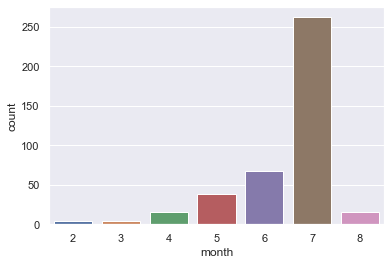

In [66]:
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)

news_data = [dp, nyt_parsed]

the_news = pd.concat(news_data)

sns.countplot(data = the_news, x = 'month')

In [81]:
other_news = [feb_news, march_news, an, may_n, june_n, july_n, aug_news, sep_news, oct_news, nov_news, dec_news]

onews = pd.concat(other_news)



In [106]:
onews['Vader'] = onews['compound']

<AxesSubplot:xlabel='month', ylabel='avgsent'>

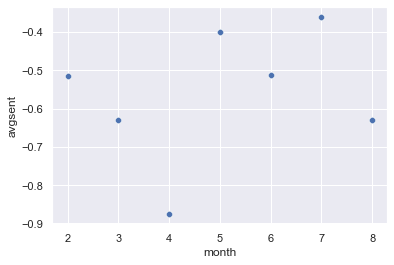

In [83]:
sns.scatterplot(data = onews, x = 'month', y = 'avgsent')

<AxesSubplot:xlabel='pos'>

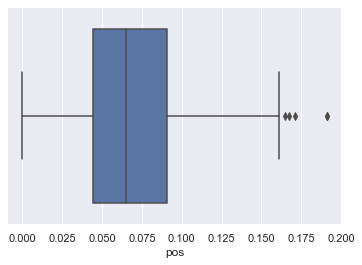

In [84]:
sns.boxplot(data = the_news, x = 'pos')

<AxesSubplot:xlabel='neu'>

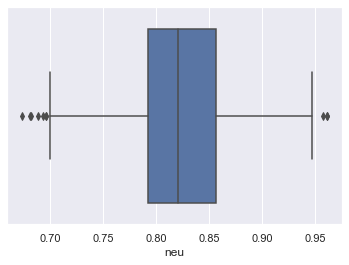

In [85]:
sns.boxplot(data = the_news, x = 'neu')

<AxesSubplot:xlabel='neg'>

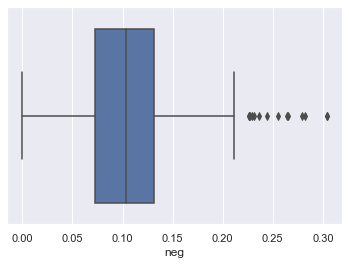

In [86]:
sns.boxplot(data = the_news, x = 'neg')

<AxesSubplot:xlabel='Vader'>

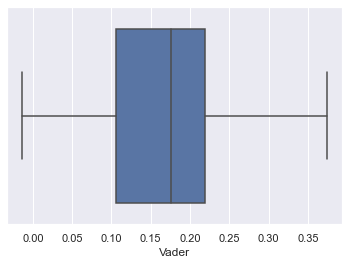

In [87]:
sns.boxplot(data = df, x = 'Vader')

In [88]:
es_uri = "https://localhost:8080/elasticsearch/"
embedding_type = 'sbert'

begin = datetime(2022, 3, 2)
end = datetime(2022, 3, 23)

date_range = [begin, end]
es_index = "ukraine-data-lite-mar23"

embedding_model = SentenceTransformer("all-MiniLM-L12-v2")
query = "Invasion"

runner = run_query(es_uri, es_index, embedding_type, embedding_model, query, date_range, max_results=500)
df2 = (pd.DataFrame(runner)).T

df2 = df2.rename(columns = {0: "Tweet embed", 1: "Tweet text", 2: "Roberta", 3: "Vader"})

print(df2)

C:\Users\Owner\anaconda3\lib\site-packages\elasticsearch\connection\http_urllib3.py:209: UserWarning: Connecting to https://localhost:8080 using SSL with verify_certs=False is insecure.
  warnings.warn(
C:\Users\Owner\anaconda3\lib\site-packages\urllib3\connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


                                           Tweet embed  \
0    (Thread: What a further Russian invasion of #U...   
1    (#DPRK 1950, #Cuba 1961, #Vietnam 1961, #Panam...   
2    (Here is the latest control-of-terrain #map fo...   
3    (#MARIUPOL—#4—Interviews with #Ukraine|ian ref...   
4    (I'll put my reputation on the line: There is ...   
..                                                 ...   
148  (A farmer joins Tucker Carlson to give a warni...   
149  (I understand times are hard, but doesn't the ...   
150  (PELOSI says she will read a poem by Bono abou...   
151  (Former U.S. Secretary of State Madeleine Albr...   
152  ("I'd rather be lied to than told something I ...   

                                            Tweet text  \
0    Tweet:<br>----------<br>Thread: What a further...   
1    Tweet:<br>----------<br>#DPRK 1950, #Cuba 1961...   
2    Tweet:<br>----------<br>Here is the latest con...   
3    Tweet:<br>----------<br>#MARIUPOL—#4—Interview...   
4    Tweet:<b

<AxesSubplot:xlabel='Vader'>

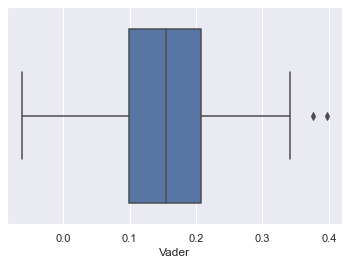

In [89]:
sns.boxplot(data = df2, x = 'Vader')

C:\Users\Owner\anaconda3\lib\site-packages\elasticsearch\connection\http_urllib3.py:209: UserWarning: Connecting to https://localhost:8080 using SSL with verify_certs=False is insecure.
  warnings.warn(
C:\Users\Owner\anaconda3\lib\site-packages\urllib3\connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<AxesSubplot:xlabel='Vader'>

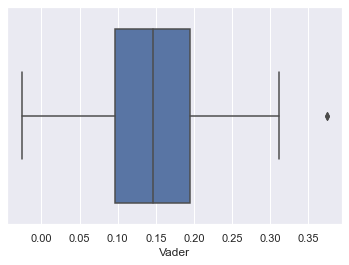

In [90]:
es_uri = "https://localhost:8080/elasticsearch/"
embedding_type = 'sbert'

begin = datetime(2022, 4, 1)
end = datetime(2022, 4, 21)

date_range = [begin, end]
es_index = "ukraine-data-lite-mar23"

embedding_model = SentenceTransformer("all-MiniLM-L12-v2")
query = "Invasion"

runner = run_query(es_uri, es_index, embedding_type, embedding_model, query, date_range, max_results=500)
df3 = (pd.DataFrame(runner)).T

df3 = df3.rename(columns = {0: "Tweet embed", 1: "Tweet text", 2: "Roberta", 3: "Vader"})

sns.boxplot(data = df3, x = 'Vader')

C:\Users\Owner\anaconda3\lib\site-packages\elasticsearch\connection\http_urllib3.py:209: UserWarning: Connecting to https://localhost:8080 using SSL with verify_certs=False is insecure.
  warnings.warn(
C:\Users\Owner\anaconda3\lib\site-packages\urllib3\connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<AxesSubplot:xlabel='Vader'>

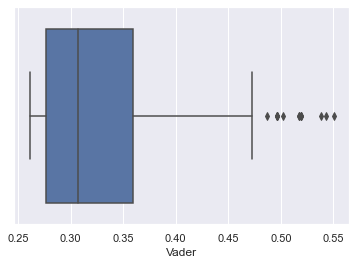

In [91]:
es_uri = "https://localhost:8080/elasticsearch/"
embedding_type = 'sbert'

begin = datetime(2022, 5, 17)
end = datetime(2022, 5, 24)

date_range = [begin, end]
es_index = "ukraine-data-lite-mar23"

embedding_model = SentenceTransformer("all-MiniLM-L12-v2")
query = "Invasion"

runner = run_query(es_uri, es_index, embedding_type, embedding_model, query, date_range, max_results=500)
df4 = (pd.DataFrame(runner)).T

df4 = df4.rename(columns = {0: "Tweet embed", 1: "Tweet text", 2: "Roberta", 3: "Vader"})

sns.boxplot(data = df4, x = 'Vader')

C:\Users\Owner\anaconda3\lib\site-packages\elasticsearch\connection\http_urllib3.py:209: UserWarning: Connecting to https://localhost:8080 using SSL with verify_certs=False is insecure.
  warnings.warn(
C:\Users\Owner\anaconda3\lib\site-packages\urllib3\connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<AxesSubplot:xlabel='Vader'>

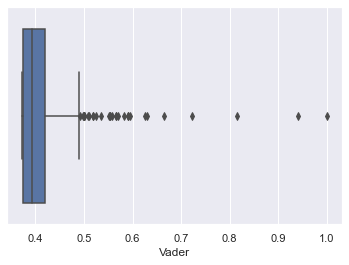

In [92]:
es_uri = "https://localhost:8080/elasticsearch/"
embedding_type = 'sbert'

begin = datetime(2022, 9, 1)
end = datetime(2022, 9, 28)

date_range = [begin, end]
es_index = "ukraine-data-lite-mar23"

embedding_model = SentenceTransformer("all-MiniLM-L12-v2")
query = "Invasion"

runner = run_query(es_uri, es_index, embedding_type, embedding_model, query, date_range, max_results=500)
df5 = (pd.DataFrame(runner)).T

df5 = df5.rename(columns = {0: "Tweet embed", 1: "Tweet text", 2: "Roberta", 3: "Vader"})

sns.boxplot(data = df5, x = 'Vader')

C:\Users\Owner\anaconda3\lib\site-packages\elasticsearch\connection\http_urllib3.py:209: UserWarning: Connecting to https://localhost:8080 using SSL with verify_certs=False is insecure.
  warnings.warn(
C:\Users\Owner\anaconda3\lib\site-packages\urllib3\connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<AxesSubplot:xlabel='Vader'>

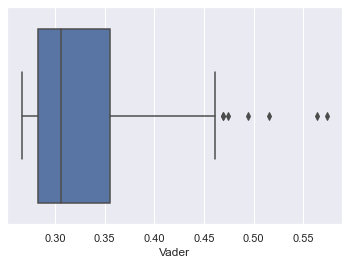

In [93]:
es_uri = "https://localhost:8080/elasticsearch/"
embedding_type = 'sbert'

begin = datetime(2022, 10, 8)
end = datetime(2022, 10, 17)

date_range = [begin, end]
es_index = "ukraine-data-lite-mar23"

embedding_model = SentenceTransformer("all-MiniLM-L12-v2")
query = "Invasion"

runner = run_query(es_uri, es_index, embedding_type, embedding_model, query, date_range, max_results=500)
df6 = (pd.DataFrame(runner)).T

df6 = df6.rename(columns = {0: "Tweet embed", 1: "Tweet text", 2: "Roberta", 3: "Vader"})

sns.boxplot(data = df6, x = 'Vader')

C:\Users\Owner\anaconda3\lib\site-packages\elasticsearch\connection\http_urllib3.py:209: UserWarning: Connecting to https://localhost:8080 using SSL with verify_certs=False is insecure.
  warnings.warn(
C:\Users\Owner\anaconda3\lib\site-packages\urllib3\connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<AxesSubplot:xlabel='Vader'>

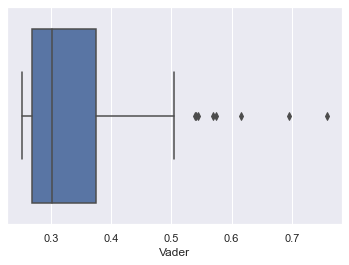

In [94]:
es_uri = "https://localhost:8080/elasticsearch/"
embedding_type = 'sbert'

begin = datetime(2022, 11, 12)
end = datetime(2022, 11, 19)

date_range = [begin, end]
es_index = "ukraine-data-lite-mar23"

embedding_model = SentenceTransformer("all-MiniLM-L12-v2")
query = "Invasion"

runner = run_query(es_uri, es_index, embedding_type, embedding_model, query, date_range, max_results=500)
df7 = (pd.DataFrame(runner)).T

df7 = df7.rename(columns = {0: "Tweet embed", 1: "Tweet text", 2: "Roberta", 3: "Vader"})

sns.boxplot(data = df7, x = 'Vader')

C:\Users\Owner\anaconda3\lib\site-packages\elasticsearch\connection\http_urllib3.py:209: UserWarning: Connecting to https://localhost:8080 using SSL with verify_certs=False is insecure.
  warnings.warn(
C:\Users\Owner\anaconda3\lib\site-packages\urllib3\connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<AxesSubplot:xlabel='Vader'>

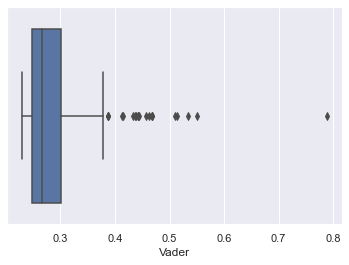

In [95]:
es_uri = "https://localhost:8080/elasticsearch/"
embedding_type = 'sbert'

begin = datetime(2022, 12, 21)
end = datetime(2022, 12, 28)

date_range = [begin, end]
es_index = "ukraine-data-lite-mar23"

embedding_model = SentenceTransformer("all-MiniLM-L12-v2")
query = "Invasion"

runner = run_query(es_uri, es_index, embedding_type, embedding_model, query, date_range, max_results=500)
df8 = (pd.DataFrame(runner)).T

df8 = df8.rename(columns = {0: "Tweet embed", 1: "Tweet text", 2: "Roberta", 3: "Vader"})

sns.boxplot(data = df8, x = 'Vader')

<AxesSubplot:xlabel='Proportion', ylabel='Vader'>

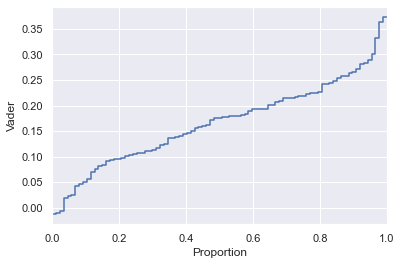

In [96]:
sns.ecdfplot(data=df, y="Vader")

<AxesSubplot:xlabel='Proportion', ylabel='Vader'>

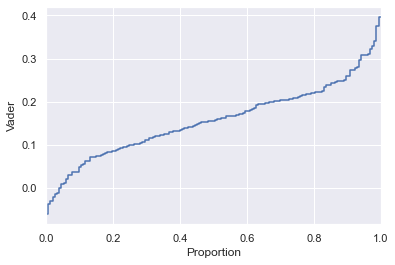

In [98]:
sns.ecdfplot(data=df2, y="Vader")

<AxesSubplot:xlabel='Proportion', ylabel='Vader'>

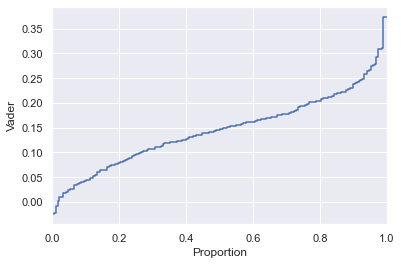

In [99]:
sns.ecdfplot(data=df3, y="Vader")

<AxesSubplot:xlabel='Proportion', ylabel='Vader'>

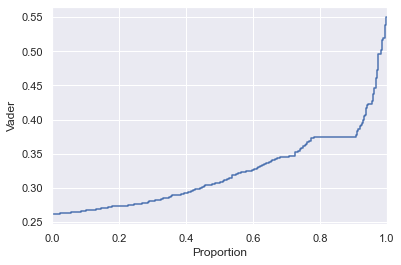

In [100]:
sns.ecdfplot(data=df4, y="Vader")

<AxesSubplot:xlabel='Proportion', ylabel='Vader'>

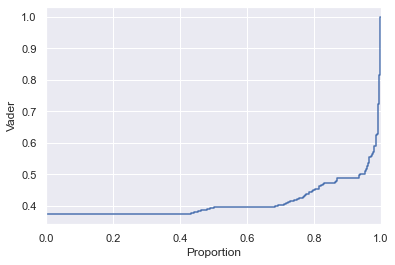

In [101]:
sns.ecdfplot(data=df5, y="Vader")

<AxesSubplot:xlabel='Proportion', ylabel='Vader'>

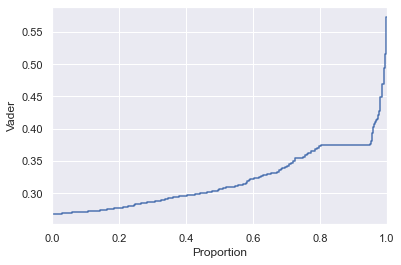

In [102]:
sns.ecdfplot(data=df6, y="Vader")

<AxesSubplot:xlabel='Proportion', ylabel='Vader'>

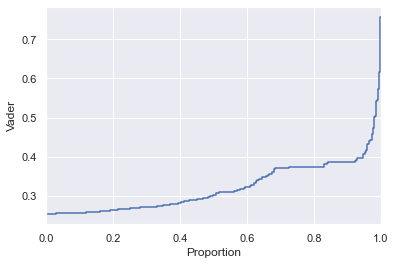

In [103]:
sns.ecdfplot(data=df7, y="Vader")

<AxesSubplot:xlabel='Proportion', ylabel='Vader'>

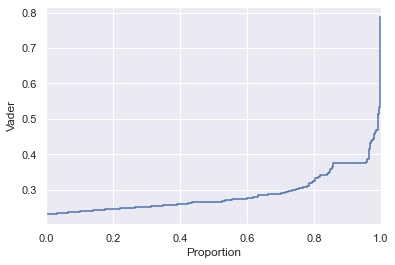

In [104]:
sns.ecdfplot(data=df8, y="Vader")

In [107]:
twit_data = [df, df2, df3, df4, df5, df6, df7, df8]

twit_sen = pd.concat(twit_data)

In [199]:
es_uri = "https://localhost:8080/elasticsearch/"
embedding_type = 'sbert'

begin = datetime(2022, 6, 1)
end = datetime(2022, 8, 30)

date_range = [begin, end]
es_index = "ukraine-data-lite-mar23"

embedding_model = SentenceTransformer("all-MiniLM-L12-v2")
query = "Invasion"

runner = run_query(es_uri, es_index, embedding_type, embedding_model, query, date_range, max_results=500)
df9 = (pd.DataFrame(runner)).T

df9 = df9.rename(columns = {0: "Tweet embed", 1: "Tweet text", 2: "Roberta", 3: "Vader"})



C:\Users\Owner\anaconda3\lib\site-packages\elasticsearch\connection\http_urllib3.py:209: UserWarning: Connecting to https://localhost:8080 using SSL with verify_certs=False is insecure.
  warnings.warn(
C:\Users\Owner\anaconda3\lib\site-packages\urllib3\connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [112]:
import re
from nltk.tokenize import word_tokenize
import nltk.corpus
from collections import Counter
from nltk.util import ngrams
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from nltk.tokenize import sent_tokenize

##REV4 = threeudf.loc[:, 'CommentContent'].to_string(header=False, index=False)

##REV4

In [133]:
twitsent = twit_sen.loc[:, 'Tweet text']

twitsent2 = pd.DataFrame(twitsent)

for i in twitsent2.iterrows():
    i = str(i)
    i.lower()
    i = re.sub(r'[^a-zA-Z0-9\s]', ' ', i)
    i = re.sub(r"www.\S+", "", i)
    i = re.sub('\[*?\]',' ', i)



In [171]:
print(twitsent2.iloc[0:2, :])

                                          Tweet text
0  Tweet:<br>----------<br>पुतिन बेशक ताक़त का पर...
1  Tweet:<br>----------<br>Graphic: Tracking Russ...


In [231]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
twit_rev = twit_sen.loc[:, 'Tweet text'].to_string(header=False, index=False)
twit_rev

lower_case_twit = twit_rev.lower()
space_normalized_twit = re.sub(r'[^a-zA-Z0-9\s]', ' ', lower_case_twit)

tokens_twit = word_tokenize(space_normalized_twit)

' '.join(tokens_twit)

stopwords_set_twit = stopwords.words("english")
stopwords_set_twit.extend(['tweet','html','http','br', 'https', 'tweet', 'pr'])
tokens_without_stopwords_twit = [token for token in tokens_twit if token not in stopwords_set_twit]


embedder = SentenceTransformer('all-MiniLM-L6-v2')  # Could use another pre-trained language model, such as 'distilbert-base-nli-mean-tokens'
web_removed_twit = re.sub(r"www.\S+", "", space_normalized_twit)
char_removed_twit = re.sub('\[*?\]',' ', web_removed_twit)
sentences22 =  char_removed_twit.replace("\ntweet"," ").replace(" br "," ").replace("       ", ".").replace("                           ", ".")
sent3 = sentences22.replace(".......", ".").replace("..", ".").replace("...", ".").replace("........", ".")
sentences_twit = sent_tokenize(sent3)
##sentences3

##print(tokens_without_stopwords_twit)
###vectorizer = TfidfVectorizer(stop_words=stopwords_set_twit,max_features=10000, max_df = 0.5, use_idf = True, ngram_range=(1,3))
X = embedder.encode(sentences_twit)
##print(X.shape) # check shape of the document-term matrix
##terms = vectorizer.get_feature_names()

##print(X)
print(sentences_twit)

['tweet.', 'graphic  tracking russi.', 'drone footage shows bri.', 'we are on pace for roug.', 'the ukraine invasion th.', 'russia s invasion of uk.', 'if it comes down to it.', 'civilized   https   t.    israeli occupation forc.', 'extraordinary footage o.   when foreigners casuall.', 'nteractive map of cross.', 'quarantinedcoof flying.', 'zelensky posts a video.', 'mediterranean rch559 r.   i learn to use  kalashn.', 'i have great news for a.   breaking  russian state.', 'the anonymous collectiv.', 'i m ready to die for u.      in  kharkiv  the occ.', 'continua attivita aerea.', 'buy sfu token fair laun.', 'a captured from the  ir.', 'bunker broadcast  bbcne.', 'putin ramping up the nu.', 'russia  ukraine  and th.', 'ukraineisgeorgefloyd b.   in a particularly egreg.', 'hannahthibedeau  supri.', '2  donate money to supp.', 'moldova  26 02 2022  fc.', 'this picture for a yeme.', 'potus  our forces are.', 'here is a ukrainian fat.', 'vladimir putin s crimin.', 'roman abramovich has be.

Most common unigrams:
[('co', 357), ('invasion', 200), ('russian', 105), ('breaking', 96), ('ukraine', 95), ('brazil', 88), ('ukrainian', 66), ('new', 63), ('russia', 58), ('today', 47), ('invoked', 41), ('1', 35), ('thing', 34), ('gener', 33), ('first', 32), ('u', 29), ('us', 29), ('st', 29), ('announcing', 28), ('war', 27)]

Most common bigrams:
[(('brazil', 'invasion'), 88), (('invasion', 'brazil'), 87), (('invoked', 'invasion'), 41), (('invasion', 'invoked'), 40), (('thing', 'gener'), 32), (('gener', 'thing'), 31), (('today', 'announcing'), 27), (('announcing', 'today'), 26), (('greene', 'five'), 21), (('five', 'mil'), 21), (('mil', 'greene'), 20), (('biden', 'says'), 17), (('first', 'trailer'), 17), (('last', 'person'), 17), (('person', 'st'), 17), (('trailer', 'first'), 16), (('st', 'last'), 15), (('sunday', 'nationa'), 14), (('co', 'eycqxate84'), 13), (('new', 'pres'), 13)]


Text(0.5, 0, '# of Occurances')

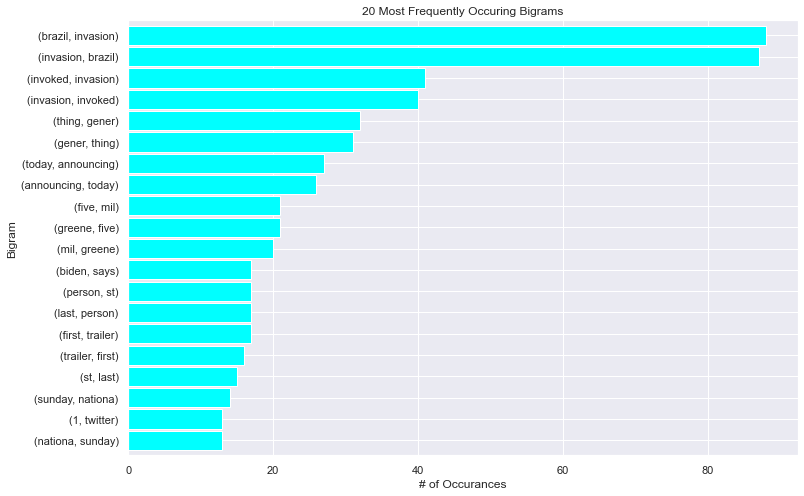

In [226]:
unigram_counter2 = Counter()
for unigram in ngrams(tokens_without_stopwords_twit, 1):
    unigram_counter2[unigram[0]] += 1
print("Most common unigrams:")
print(unigram_counter2.most_common(20))
print()

bigram_counter2 = Counter()
for bigram in ngrams(tokens_without_stopwords_twit, 2):
    bigram_counter2[bigram] += 1
print("Most common bigrams:")
print(bigram_counter2.most_common(20))

bigrams_series = (pd.Series(nltk.ngrams(tokens_without_stopwords_twit, 2)).value_counts())[:20]

bigrams_series.sort_values().plot.barh(color='cyan', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

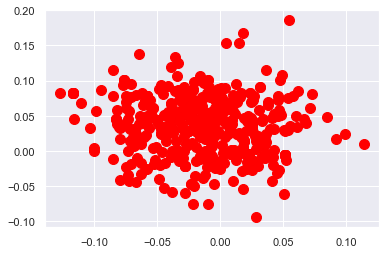

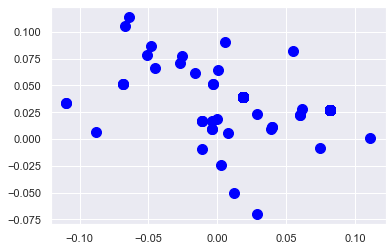

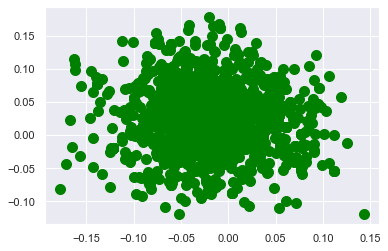

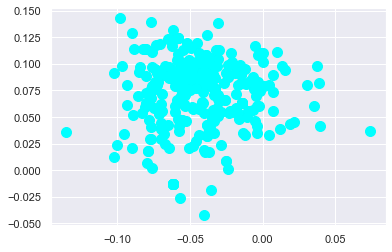

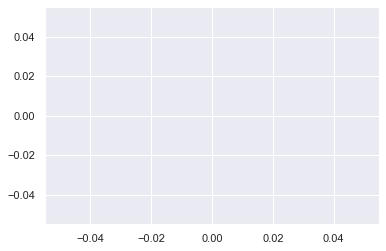

In [235]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)
labeks = kmeans.fit_predict(X)

'''
# Import pyplot
# Assign the columns of new_points: xs and ys
xs = X[:,0]
ys = X[:,1]
print(xs)
'''
'''
# Make a scatter plot of xs and ys, using labels to define the colors

u_labs = np.unique(labeks)

'''
'''
plt.scatter(xs,ys,c=u_labs,alpha=0.5)
# Assign the cluster centers: centroids
centroids = kmeans.cluster_centers_
# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]
# Make a scatter plot of centroids_x and centroids_y
plt.scatter(centroids_x,centroids_y,marker='D',s=50)
plt.show()
'''
#Getting unique labels
'''
u_labels = np.unique(labeks)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(X[labeks == i , 0] , X[labeks == i , 1] , labeks = i)
plt.legend()
plt.show()
'''


plt.scatter(X[labeks==0, 0], X[labeks==0, 1], s=100, c='red', label ='Cluster 1')
plt.show()
plt.scatter(X[labeks==1, 0], X[labeks==1, 1], s=100, c='blue', label ='Cluster 2')
plt.show()
plt.scatter(X[labeks==2, 0], X[labeks==2, 1], s=100, c='green', label ='Cluster 3')
plt.show()
plt.scatter(X[labeks==3, 0], X[labeks==3, 1], s=100, c='cyan', label ='Cluster 4')
plt.show()
plt.scatter(X[labeks==4, 0], X[labeks==4, 1], s=100, c='magenta', label ='Cluster 5')
plt.show()


In [209]:
onews_rev = onews.loc[:, 'articles'].to_string(header=False, index=False)
onews_rev

lower_case_onew = onews_rev.lower()
space_normalized_onew = re.sub(r'[^a-zA-Z0-9\s]', ' ', lower_case_onew)

tokens_onew = word_tokenize(space_normalized_onew)

' '.join(tokens_onew)

stopwords_set_onew = stopwords.words("english")
stopwords_set_onew.extend(['tweet','html','http','br'])
tokens_without_stopwords_onew = [token for token in tokens_onew if token not in stopwords_set_onew]


embedder = SentenceTransformer('all-MiniLM-L6-v2')  # Could use another pre-trained language model, such as 'distilbert-base-nli-mean-tokens'
web_removed_onew = re.sub(r"www.\S+", "", space_normalized_onew)
char_removed_onew = re.sub('\[*?\]',' ', web_removed_onew)
sentences22 =  char_removed_onew.replace("\ntweet"," ").replace(" br "," ").replace("       ", ".").replace("                           ", ".")
sent3 = sentences22.replace("\n", " ").replace("    ", ".").replace("...", ".").replace("........", ".")
sentences_onew = sent_tokenize(sent3)
##sentences3

##print(tokens_without_stopwords_twit)
###vectorizer = TfidfVectorizer(stop_words=stopwords_set_twit,max_features=10000, max_df = 0.5, use_idf = True, ngram_range=(1,3))
X = embedder.encode(sentences_onew)
##print(X.shape) # check shape of the document-term matrix
##terms = vectorizer.get_feature_names()

##print(X)
print(sentences_onew)

['switzerland  a bastion of neutrality through tw.russia s attack on ukraine began at about 5am l.western leaders have spent the past 20 years tr.top story  kremlin invokes  demilitarisation  a.a russian court has banned facebook and instagr.tui  europe s largest holiday company  has canc.top story  moscow  setting stage for false flag.russia has stepped up attempts to encircle defe.russia has bombarded ukraine s second city  kha.ukraine s president volodymyr zelenskiy has sai.seven people have been killed after a huge fire.oleksandr malish  the patrol police chief for t.russia s large scale offensive to seize the don.a criminal case has been opened against a siber.a pro russian cavalcade in dublin led by a car.', 'a metro mayor has threatened to halt a popular.', 'good morning  r n r naustria s chancellor is to.good morning  r n r nrussia hit kyiv with cruis.russia has stepped up the pace of its offensive.russia has nearly doubled its revenues from sel.good morning  r n r nrussia s fo

Most common unigrams:
[('russia', 71), ('ukraine', 51), ('russian', 34), ('r', 34), ('said', 23), ('president', 19), ('n', 19), ('ukrainian', 16), ('putin', 16), ('forces', 15), ('u', 14), ('first', 11), ('uk', 10), ('mr', 10), ('2022', 10), ('people', 9), ('washington', 9), ('western', 8), ('minister', 8), ('germany', 8)]

Most common bigrams:
[(('r', 'n'), 14), (('n', 'r'), 14), (('russian', 'forces'), 10), (('president', 'volodymyr'), 6), (('vladimir', 'putin'), 6), (('jul', '2022'), 6), (('boris', 'johnson'), 5), (('ukraine', 'president'), 4), (('volodymyr', 'zelenskiy'), 4), (('good', 'morning'), 4), (('morning', 'r'), 4), (('foreign', 'minister'), 4), (('war', 'ukraine'), 4), (('ukrainian', 'forces'), 4), (('president', 'vladimir'), 4), (('ukraine', 'russia'), 4), (('people', 'killed'), 3), (('president', 'recep'), 3), (('recep', 'tayyip'), 3), (('biden', 'administration'), 3)]
                    bigrams  count
0                    (r, n)     14
1                    (n, r)     1

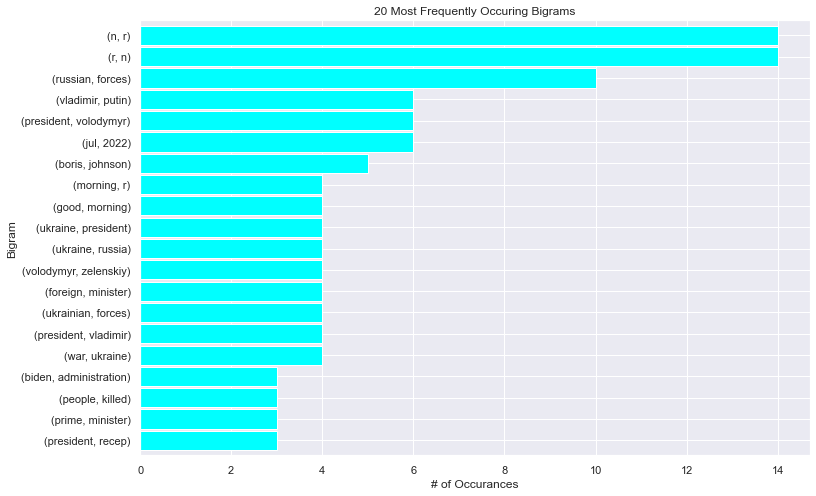

In [224]:
unigram_counter2 = Counter()
for unigram in ngrams(tokens_without_stopwords_onew, 1):
    unigram_counter2[unigram[0]] += 1
print("Most common unigrams:")
print(unigram_counter2.most_common(20))
print()

bigram_counter2 = Counter()
for bigram in ngrams(tokens_without_stopwords_onew, 2):
    bigram_counter2[bigram] += 1
print("Most common bigrams:")
print(bigram_counter2.most_common(20))

bigrams_series_onew = bigram_counter2.most_common(20)
unigrams_series_onew = unigram_counter2.most_common(20)

bso = pd.DataFrame(bigrams_series_onew, columns = ['bigrams', 'count'])
uso = pd.DataFrame(unigrams_series_onew, columns = ['unigrams', 'count'])

bso2 = bso.squeeze()


bigrams_series = (pd.Series(nltk.ngrams(tokens_without_stopwords_onew, 2)).value_counts())[:20]

bigrams_series.sort_values().plot.barh(color='cyan', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')



print(bso)

In [222]:
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)

sns.barplot(data = uso, x = ['unigrams'], y = ['count'])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

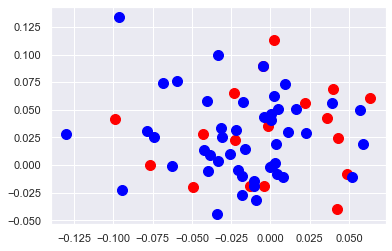

In [191]:
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)
labeks = kmeans.fit_predict(X)

'''
# Import pyplot
# Assign the columns of new_points: xs and ys
xs = X[:,0]
ys = X[:,1]
print(xs)
'''
'''
# Make a scatter plot of xs and ys, using labels to define the colors

u_labs = np.unique(labeks)

'''
'''
plt.scatter(xs,ys,c=u_labs,alpha=0.5)
# Assign the cluster centers: centroids
centroids = kmeans.cluster_centers_
# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]
# Make a scatter plot of centroids_x and centroids_y
plt.scatter(centroids_x,centroids_y,marker='D',s=50)
plt.show()
'''
#Getting unique labels
'''
u_labels = np.unique(labeks)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(X[labeks == i , 0] , X[labeks == i , 1] , labeks = i)
plt.legend()
plt.show()
'''


plt.scatter(X[labeks==0, 0], X[labeks==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X[labeks==1, 0], X[labeks==1, 1], s=100, c='blue', label ='Cluster 2')
plt.show()

In [194]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


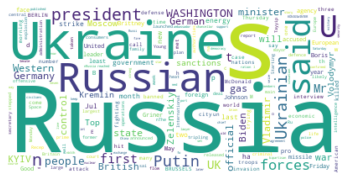

In [197]:
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(onews_rev)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

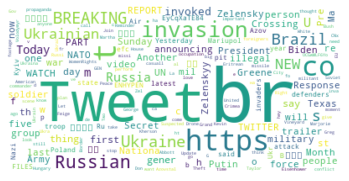

In [198]:
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(twit_rev)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [229]:
twit2_rev2 = df9.loc[:, 'Tweet text'].to_string(header=False, index=False)

lower_case_twit2 = twit2_rev2.lower()
space_normalized_twit2 = re.sub(r'[^a-zA-Z0-9\s]', ' ', lower_case_twit2)

tokens_twit2 = word_tokenize(space_normalized_twit2)

' '.join(tokens_twit2)

stopwords_set_twit2 = stopwords.words("english")
stopwords_set_twit2.extend(['tweet','html','http','br', 'https', 'ParadoXXX', 'Enhyphen', 'Tweet', 'paradoxxx', 'enhyphen'])
tokens_without_stopwords_twit2 = [token for token in tokens_twit2 if token not in stopwords_set_twit2]


embedder = SentenceTransformer('all-MiniLM-L6-v2')  # Could use another pre-trained language model, such as 'distilbert-base-nli-mean-tokens'
web_removed_twit2 = re.sub(r"www.\S+", "", space_normalized_twit2)
char_removed_twit2 = re.sub('\[*?\]',' ', web_removed_twit2)
sentences22 =  char_removed_twit2.replace("\ntweet"," ").replace(" br "," ").replace("       ", ".").replace("                           ", ".")
sent3 = sentences22.replace(".......", ".").replace("..", ".").replace("...", ".").replace("........", ".")
sentences_twit2 = sent_tokenize(sent3)
##sentences3

##print(tokens_without_stopwords_twit2)
###vectorizer = TfidfVectorizer(stop_words=stopwords_set_twit2,max_features=10000, max_df = 0.5, use_idf = True, ngram_range=(1,3))
X = embedder.encode(sentences_twit2)
##print(X.shape) # check shape of the document-term matrix
##terms = vectorizer.get_feature_names()

##print(X)
print(sentences_twit2)

['tweet.', 'this is an invasion.', 'this is an invasion.', 'this is a fucking invas.', 'this is a fucking invas.', 'stop  this fucking inva.', 'this is a damn invasion.', 'looks like an invasion.', 'looks like an invasion.', 'with each step the inv.', 'complete invasion   can.', 'a13kcf1  livepddave1 d.   civilization ending inv.', 'looking forward to the.', 'darkfarces realistical.', 'paradoxxx invasion mv i.   invasion  3re photo  ka.', 'manifesting circle.. manifesting circle.. secret invasion is doin.', 'secret invasion  drops.', 'fake alien invasion wil.', 'paradoxxx invasion teas.', 'the invasion of europe.', 'paradoxxx invasion mv.', 'a thousand a day  all y.   nicki s uk invasion htt.', 'it s gon be paradoxxx i.   the hostile invasion an.', 'one of the largest migr.', 'i swear the meaning of.', 'i swear the meaning of.', 'hell yes it s an invasi.', 'hell yes it s an invasi.', 'first time in nations h.   first time in nations h.   stop the border invasio.', 'fyi listen to the li

Most common unigrams:
[('co', 78), ('invasion', 74), ('enhypen', 61), ('lt', 48), ('musi', 13), ('inv', 10), ('new', 9), ('like', 7), ('engenes', 7), ('texas', 7), ('page', 7), ('declare', 7), ('secret', 6), ('russian', 6), ('reg', 6), ('jean', 6), ('russia', 6), ('think', 6), ('alien', 5), ('gon', 5)]

Most common bigrams:
[(('enhypen', 'lt'), 44), (('lt', 'enhypen'), 40), (('invasion', 'musi'), 13), (('musi', 'invasion'), 12), (('secret', 'invasion'), 6), (('reg', 'jean'), 6), (('jean', 'page'), 6), (('alien', 'invasion'), 4), (('page', 'offic'), 4), (('gon', 'na'), 4), (('texas', 'lt'), 4), (('lt', 'gov'), 4), (('gov', 'dan'), 4), (('dan', 'patr'), 4), (('pakistan', 'invasion'), 4), (('nato', 'chief'), 4), (('chief', 'admits'), 4), (('invasion', 'invasion'), 3), (('looks', 'like'), 3), (('enhypen', 'inv'), 3)]


Text(0.5, 0, '# of Occurances')

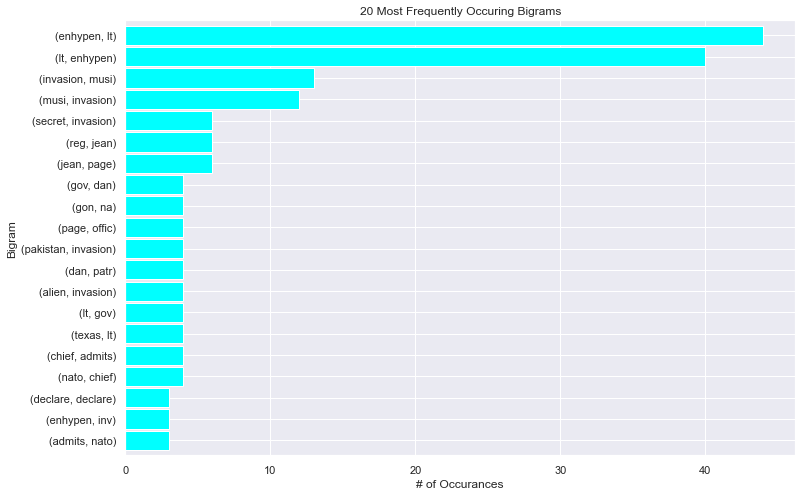

In [230]:
unigram_counter2 = Counter()
for unigram in ngrams(tokens_without_stopwords_twit2, 1):
    unigram_counter2[unigram[0]] += 1
print("Most common unigrams:")
print(unigram_counter2.most_common(20))
print()

bigram_counter2 = Counter()
for bigram in ngrams(tokens_without_stopwords_twit2, 2):
    bigram_counter2[bigram] += 1
print("Most common bigrams:")
print(bigram_counter2.most_common(20))

bigrams_series = (pd.Series(nltk.ngrams(tokens_without_stopwords_twit2, 2)).value_counts())[:20]

bigrams_series.sort_values().plot.barh(color='cyan', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

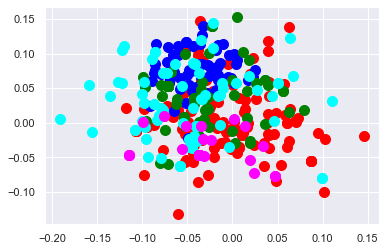

In [202]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)
labeks = kmeans.fit_predict(X)

'''
# Import pyplot
# Assign the columns of new_points: xs and ys
xs = X[:,0]
ys = X[:,1]
print(xs)
'''
'''
# Make a scatter plot of xs and ys, using labels to define the colors

u_labs = np.unique(labeks)

'''
'''
plt.scatter(xs,ys,c=u_labs,alpha=0.5)
# Assign the cluster centers: centroids
centroids = kmeans.cluster_centers_
# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]
# Make a scatter plot of centroids_x and centroids_y
plt.scatter(centroids_x,centroids_y,marker='D',s=50)
plt.show()
'''
#Getting unique labels
'''
u_labels = np.unique(labeks)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(X[labeks == i , 0] , X[labeks == i , 1] , labeks = i)
plt.legend()
plt.show()
'''


plt.scatter(X[labeks==0, 0], X[labeks==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X[labeks==1, 0], X[labeks==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(X[labeks==2, 0], X[labeks==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(X[labeks==3, 0], X[labeks==3, 1], s=100, c='cyan', label ='Cluster 4')
plt.scatter(X[labeks==4, 0], X[labeks==4, 1], s=100, c='magenta', label ='Cluster 5')
plt.show()


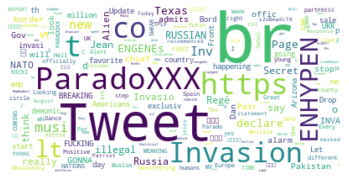

In [203]:
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(twit2_rev2)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
sentences22 = REV4.replace("\n"," ").replace("...",".").replace("        ", " ")
sentences22

lower_case_text2 = sentences22.lower()
space_normalized_text2 = re.sub(r'[^a-zA-Z0-9\s]', ' ', lower_case_text2)

tokens2 = word_tokenize(space_normalized_text2)

' '.join(tokens2)

stopwords_set2 = set(nltk.corpus.stopwords.words("english"))
tokens_without_stopwords2 = [token for token in tokens2 if token not in stopwords_set2]
tokens_without_stopwords2

embedder = SentenceTransformer('all-MiniLM-L6-v2')  # Could use another pre-trained language model, such as 'distilbert-base-nli-mean-tokens'

sentences3 = sent_tokenize(sentences22)
sentences3
X = embedder.encode(sentences3)

